# Estimation of tree height using GEDI dataset - Support Vector Machine for Regression (SVR) - 2023

Let's see a quick example of how to use Suppor Vector Regression for tree height estimation

    jupyther-notebook Tree_Height_04SVM_pred_2023.ipynb

Packages

    pip3 install pytorch torchvision torchaudio scikit-learn pandas


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import scipy

# For visualization
import rasterio
from rasterio import *
from rasterio.plot import show
from pyspatialml import Raster
from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split,GridSearchCV
# from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

We will load the data using Pandas and display few samples of it

In [2]:
# data = pd.read_csv("./tree_height_2/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
# pd.set_option('display.max_columns',None)

# print(data.shape)
# data.head(10)
predictors = pd.read_csv("./tree_height_2/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude'} , axis='columns')
predictors.head(10)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


As explained in the previous lecture, 'h' is the estimated tree heigth. So let's use it as our target.

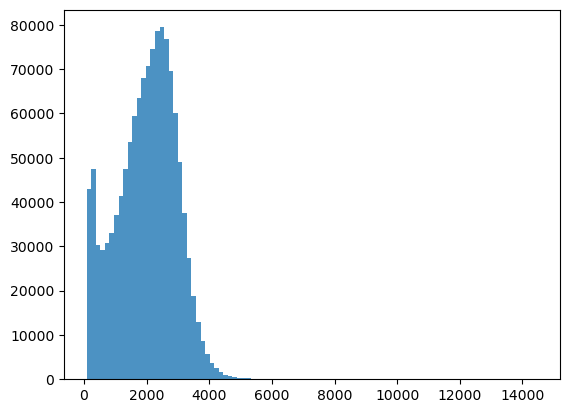

In [3]:
bins = np.linspace(min(predictors['h']),max(predictors['h']),100)
plt.hist((predictors['h']),bins,alpha=0.8);

In [4]:
predictors_sel = predictors.loc[(predictors['h'] < 7000)  ].sample(100000)
predictors_sel.insert ( 4, 'hm' ,  predictors_sel['h']/100 ) # add a col of heigh in meters
print(len(predictors_sel))
predictors_sel.head(10)

100000


,ID,X,Y,h,hm,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
314189,314190,7.019865,49.703032,3208.00,32.0800,1377,10,2395,5690,-31.017696,-191780608,2.957162,-0.012165,649.717590,10,667.820068,463.670654,-39.361328,-0.006963,28,803881,22.027813,418.627747,95
496802,496803,7.453095,49.838552,1594.00,15.9400,1462,12,2018,6099,4.706795,-189148608,0.799485,0.064142,397.831604,22,-73.028320,-96.732666,-68.537598,-0.070241,12,604939,18.339499,443.616333,83
214185,214186,6.769923,49.937723,2741.25,27.4125,1534,12,1991,6151,-26.909725,-315912576,-1.156398,0.046102,269.274170,18,208.921875,21.610840,-102.270020,-0.193569,15,665763,19.900623,460.388519,79
1102750,1102751,9.346924,49.593979,2085.00,20.8500,1463,10,2170,6425,-12.567190,-240594976,1.257921,-0.092352,423.636871,25,37.512695,-103.102539,-9.143555,0.030144,12,729055,19.228687,451.815948,87
478661,478662,7.401212,49.598814,1883.50,18.8350,1512,15,2048,6271,10.439974,-351287040,-1.081400,0.045427,318.814331,25,168.426025,123.145020,248.555664,0.126946,11,623203,19.742725,454.855927,96
809886,809887,8.616201,48.868057,340.00,3.4000,1514,18,2385,6433,-3.628073,-209369520,0.641144,-0.017633,391.828796,4,933.261230,634.117432,542.653809,0.058795,7,747698,20.744087,492.085907,13
679461,679462,7.980072,49.680752,2379.00,23.7900,1541,11,1892,6239,-20.685070,-138075056,1.200781,-0.052553,347.009552,25,-27.094971,-89.953613,-156.206299,0.020362,12,588156,17.547787,458.630371,95
200517,200518,6.734687,48.927598,1513.00,15.1300,1540,13,2146,6264,7.081443,-45983820,-0.935434,0.007613,237.065109,0,657.542969,629.276611,582.212402,-0.032703,12,861020,18.124147,466.832214,90
928805,928806,8.917724,49.644695,2908.50,29.0850,1483,13,2629,6331,33.069771,-262037664,1.201575,0.084139,378.784515,27,84.257812,-63.966797,10.501709,0.169573,14,738552,19.076752,473.688354,85
240296,240297,6.834607,49.672558,2677.50,26.7750,1389,11,2572,5573,-28.345655,-239594144,3.465430,-0.011193,694.449707,28,821.419922,357.111084,277.945312,-0.070467,36,807597,23.452335,416.131592,85


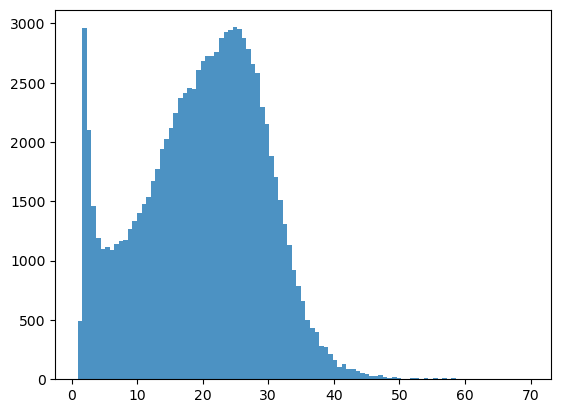

In [5]:
bins = np.linspace(min(predictors_sel['hm']),max(predictors_sel['hm']),100)
plt.hist((predictors_sel['hm']),bins,alpha=0.8);

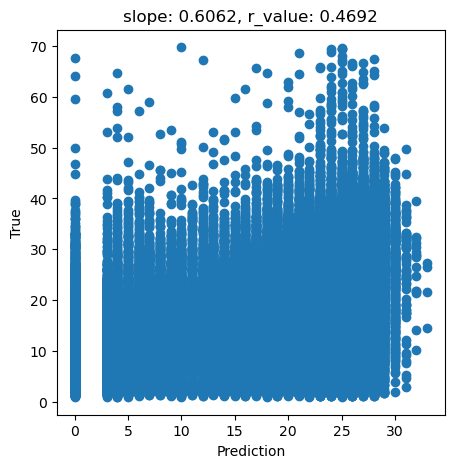

In [6]:
# What we are trying to beat
y_true = predictors_sel['hm']
y_pred = predictors_sel['forestheight']

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_true)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(y_pred, y_true)
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
plt.show()

In [7]:
tree_height = predictors_sel['hm'].to_numpy()
data = predictors_sel.drop(columns=['ID','h','X','Y', 'hm','forestheight'], axis=1)

Now we will split the data into training vs test datasets and perform the normalization.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.to_numpy()[:20000,:],tree_height[:20000], random_state=0)
print('X_train.shape:{}, X_test.shape:{} '.format(X_train.shape, X_test.shape))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape:(15000, 18), X_test.shape:(5000, 18) 


Now, we will build our SVR regressor. For more details on all the parameters it accepts, please check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [9]:
svr = SVR()
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.23058
Accuracy of SVR on test set: 0.22722


In [10]:
svr = SVR(epsilon=0.01)
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.23066
Accuracy of SVR on test set: 0.22718


In [11]:
svr = SVR(epsilon=0.01, C=2.0)
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.23975
Accuracy of SVR on test set: 0.23422


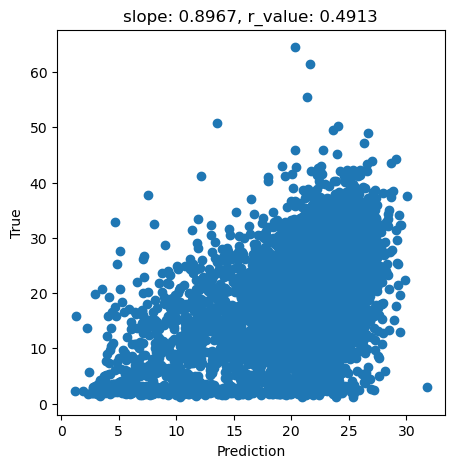

In [12]:
y_pred = svr.predict(X_test)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(y_pred, y_test)
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
plt.show()

In [13]:
svr = SVR(kernel='linear',epsilon=0.01, C=2.0)
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.18166
Accuracy of SVR on test set: 0.17481


In [14]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.18179
Accuracy of SVR on test set: 0.17514


In [15]:
svr

SVR(kernel='linear')

In [20]:
# import satalite indeces
glad_ard_SVVI_min = "./tree_height_2/geodata_raster/glad_ard_SVVI_min.tif"
glad_ard_SVVI_med = "./tree_height_2/geodata_raster/glad_ard_SVVI_med.tif"
glad_ard_SVVI_max = "./tree_height_2/geodata_raster/glad_ard_SVVI_max.tif"

# import climate
CHELSA_bio4 = "./tree_height_2/geodata_raster/CHELSA_bio4.tif"
CHELSA_bio18 = "./tree_height_2/geodata_raster/CHELSA_bio18.tif"

# soil
BLDFIE_WeigAver = "./tree_height_2/geodata_raster/BLDFIE_WeigAver.tif"
CECSOL_WeigAver = "./tree_height_2/geodata_raster/CECSOL_WeigAver.tif"
ORCDRC_WeigAver = "./tree_height_2/geodata_raster/ORCDRC_WeigAver.tif"

# Geomorphological
elev = "./tree_height_2/geodata_raster/elev.tif"
convergence = "./tree_height_2/geodata_raster/convergence.tif"
northness = "./tree_height_2/geodata_raster/northness.tif"
eastness = "./tree_height_2/geodata_raster/eastness.tif"
devmagnitude = "./tree_height_2/geodata_raster/dev-magnitude.tif"

# Hydrography
cti = "./tree_height_2/geodata_raster/cti.tif"
outlet_dist_dw_basin = "./tree_height_2/geodata_raster/outlet_dist_dw_basin.tif"

# Soil climate

SBIO3_Isothermality_5_15cm = "./tree_height_2/geodata_raster/SBIO3_Isothermality_5_15cm.tif"
SBIO4_Temperature_Seasonality_5_15cm = "./tree_height_2/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif"

# forest

treecover = "./tree_height_2/geodata_raster/treecover.tif"

In [21]:
predictors_rasters = [glad_ard_SVVI_min, glad_ard_SVVI_med, glad_ard_SVVI_max,
                      CHELSA_bio4,CHELSA_bio18,
                      BLDFIE_WeigAver,CECSOL_WeigAver, ORCDRC_WeigAver,
                      elev,convergence,northness,eastness,devmagnitude,cti,outlet_dist_dw_basin,
                      SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover]
print(predictors_rasters)
stack = Raster(predictors_rasters)

['./tree_height_2/geodata_raster/glad_ard_SVVI_min.tif', './tree_height_2/geodata_raster/glad_ard_SVVI_med.tif', './tree_height_2/geodata_raster/glad_ard_SVVI_max.tif', './tree_height_2/geodata_raster/CHELSA_bio4.tif', './tree_height_2/geodata_raster/CHELSA_bio18.tif', './tree_height_2/geodata_raster/BLDFIE_WeigAver.tif', './tree_height_2/geodata_raster/CECSOL_WeigAver.tif', './tree_height_2/geodata_raster/ORCDRC_WeigAver.tif', './tree_height_2/geodata_raster/elev.tif', './tree_height_2/geodata_raster/convergence.tif', './tree_height_2/geodata_raster/northness.tif', './tree_height_2/geodata_raster/eastness.tif', './tree_height_2/geodata_raster/dev-magnitude.tif', './tree_height_2/geodata_raster/cti.tif', './tree_height_2/geodata_raster/outlet_dist_dw_basin.tif', './tree_height_2/geodata_raster/SBIO3_Isothermality_5_15cm.tif', './tree_height_2/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif', './tree_height_2/geodata_raster/treecover.tif']


In [22]:
result = stack.predict(estimator=svr, dtype='int16', nodata=-1)

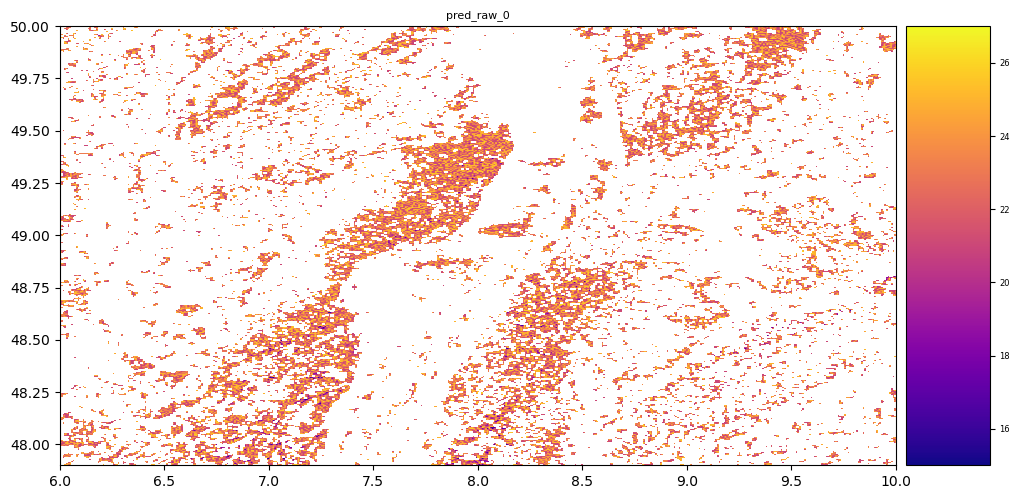

In [23]:
# plot regression result
plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
result.plot()
plt.show()

Exercise: explore the other parameters offered by the SVM library and try to make the model better. Some suggestions:
- Better cleaning of the data (follow Peppe's suggestions)
- Stronger regularization might be helpful
- Play with different kernels

<span style="color:red">**For the brave ones**</span>, try to implenent the SVR algorithm from scratch. As we saw in class, the algorithm is quite simple. Here is a simple sketch of the SVM algorithm. Make the appropriate modifications to turn it into a regression. Let us know if your implementation is better than sklearn's. 

In [24]:
## Support Vector Machine 
import numpy as np

train_f1 = x_train[:,0]
train_f2 = x_train[:,1]

train_f1 = train_f1.reshape(90,1)
train_f2 = train_f2.reshape(90,1)

w1 = np.zeros((90,1))
w2 = np.zeros((90,1))

epochs = 1
alpha = 0.0001

while(epochs < 10000):
    y = w1 * train_f1 + w2 * train_f2
    prod = y * y_train
    print(epochs)
    count = 0
    for val in prod:
        if(val >= 1):
            cost = 0
            w1 = w1 - alpha * (2 * 1/epochs * w1)
            w2 = w2 - alpha * (2 * 1/epochs * w2)
            
        else:
            cost = 1 - val 
            w1 = w1 + alpha * (train_f1[count] * y_train[count] - 2 * 1/epochs * w1)
            w2 = w2 + alpha * (train_f2[count] * y_train[count] - 2 * 1/epochs * w2)
        count += 1
    epochs += 1

NameError: name 'x_train' is not defined